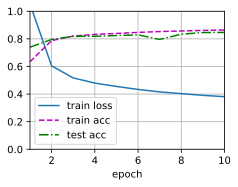

In [1]:
import torch
from torch import nn
from utils.loader import load_data_fashion_mnist
from utils.train import train_ch3,predict_ch3
from utils.animation import Animator
from utils.accumulator import Accumulator

batch_size = 256
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'使用设备类型: {device}')
train_iter, test_iter = load_data_fashion_mnist(batch_size)

num_inputs, num_outputs, num_hiddens = 784, 10, 256

# by hand
# 这里为什么要用nn.Parameter包一次？因为这里的张量经过了一次计算（乘以一个常数），就变成了中间节点，不会保存梯度。需要手动再处理如下：
# W1 = (torch.randn(num_inputs, num_hiddens, requires_grad=True,device=device) * 0.01).detach().requires_grad_(True)
# b1 = torch.zeros(num_hiddens, requires_grad=True,device=device)
# W2 = (torch.randn(num_hiddens, num_outputs, requires_grad=True,device=device) * 0.01).detach().requires_grad_(True)
# b2 = torch.zeros(num_outputs, requires_grad=True,device=device)
# 为了简单，直接使用nn.Parameter包一层，就能保证张量一定会被保留梯度
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True,device=device) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True,device=device))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True,device=device) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True,device=device))

params = [W1, b1, W2, b2]

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

def evaluate(data_iter,net):
    acc = Accumulator(2)
    with torch.no_grad():
        for x,y in data_iter:
            x,y = x.to(device),y.to(device)
            y_hat = net(x)
            accurate_num = accuracy(y,y_hat)
            acc.add(accurate_num,y.numel())
    return acc[0]/acc[1]

# 计算的一个批量中准确的样本数量，不是准确率
# 注意这里的y和y_hat是不一样的，
# y是一个一维的向量，每个元素表示类别的索引，
# y_hat是一个二维矩阵，0维长度是样本长度，1维长度是类别数量，数值表示概率
def accuracy(y,y_hat:torch.Tensor):
    y_hat = y_hat.argmax(dim=-1)
    if y_hat.dim() > 1:
        y_hat = y_hat.squeeze(-1)
    y = y.to(y_hat.device)
    return (y == y_hat).sum().detach()

def mlp_by_hand_train_epoch(data_iter,loss,updater,net):
    acc = Accumulator(3)
    for x,y in data_iter:
        x,y = x.to(device),y.to(device)
        y_hat = net(x)
        # 注意，这里的y_hat和y的顺序不能乱
        l = loss(y_hat,y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        acc.add(l.sum().detach(),accuracy(y,y_hat),y.numel())
    return acc[0]/acc[2],acc[1]/acc[2]

def mlp_by_hand_train(net, train_iter,test_iter,loss,updater,num_epochs):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.2, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = mlp_by_hand_train_epoch(train_iter,loss,updater,net)
        test_acc  = evaluate(test_iter,net)
        animator.add(epoch+1,train_metrics+(test_acc,))

loss = nn.CrossEntropyLoss(reduction='none')
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
mlp_by_hand_train(net,train_iter,test_iter,loss,updater,num_epochs)


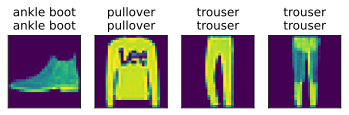

In [ ]:
from utils.train import show_images

def get_label_text_by_idx(label_idxs):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[idx] for idx in label_idxs]

def mlp_by_hand_predict(net, data_iter, n=6):
    first_batch = next(iter(data_iter))
    x,y = first_batch
    x = x.to(device)
    y_hat = net(x)
    y_hat_idxs = y_hat.argmax(-1)
    preds = get_label_text_by_idx(y_hat_idxs)
    trues = get_label_text_by_idx(y)
    titles = [true + '\n' + pred for true,pred in zip(trues, preds)]
    show_images(x[:n].to('cpu').reshape(-1,28,28),1,n,titles=titles)

mlp_by_hand_predict(net,test_iter,4)

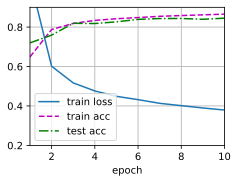

In [2]:
# by nn
from torch import nn
import torch
from utils.loader import load_data_fashion_mnist
from utils.animation import Animator
from utils.accumulator import Accumulator

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'使用设备类型: {device}')
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256,device=device),
                    nn.ReLU(),
                    nn.Linear(256, 10,device=device))

def init_model(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight,0,0.01)
        nn.init.zeros_(layer.bias)

net.apply(init_model)

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# y_hat是二维矩阵,y 是一维向量
def accuracy(y_hat:torch.Tensor,y:torch.Tensor):
    with torch.no_grad():
        y_hat = y_hat.argmax(-1)
        return (y == y_hat).sum().detach()

def evaluate(data_iter,net):
    acc = Accumulator(2)
    with torch.no_grad():
        for x,y in data_iter:
            x,y = x.to(device),y.to(device)
            y_hat = net(x)
            accurate_num = accuracy(y_hat,y)
            acc.add(accurate_num,y.numel())
    return acc[0]/acc[1]

def mlp_by_nn_train_epoch(net: nn.Module,train_iter, loss, trainer:torch.optim.Optimizer):
    acc = Accumulator(3)
    for x, y in train_iter:
        x,y = x.to(device),y.to(device)
        y_hat = net(x)
        l = loss(y_hat,y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        acc.add(float(l.sum().detach()),accuracy(y_hat,y),y.numel())
    return acc[0]/acc[2],acc[1]/acc[2]


def mlp_by_nn_train(net:nn.Module,train_iter,test_iter,loss,trainer,num_epoch):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.2, 0.9],
                legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epoch):
        # 切换到训练模式
        net.train()
        metrics = mlp_by_nn_train_epoch(net,train_iter,loss,trainer)
        # 切换到评估模式
        net.eval()
        test_acc = evaluate(test_iter,net)
        metrics = metrics + (test_acc,)
        animator.add(epoch+1,metrics)
            
mlp_by_nn_train(net, train_iter, test_iter, loss, trainer,num_epochs)

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

def get_label_text_by_idx(labels)->list[str]:
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
            'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[label_idx] for label_idx in labels]

def mlp_by_nn_predict(data_iter,net,n=6):
    x,y = next(iter(data_iter))
    x = x.to(device)
    y_hat = net(x)
    y_hat_idx = y_hat.argmax(-1)
    nonequal_idx = (y_hat_idx == y).where()
    nonequal_preds_idx = y_hat_idx[nonequal_idx]
    nonequal_trues_idx = y[nonequal_idx]

    preds = get_label_text_by_idx(y_hat_idx)
    trues = get_label_text_by_idx(y)
    titles = [ true + '\n' + pred for pred, true in zip(nonequal_preds,nonequal_trues)]
    show_images(x[:n].to('cpu').reshape(-1,28,28),1,n,titles)

mlp_by_nn_predict(test_iter,net,4)


AttributeError: 'bool' object has no attribute 'nonzeros'